In [1]:
import pandas as pd
import joblib

In [15]:
from collections import Counter

In [18]:
model_data = model_data.drop(model_data[model_data["rating"]=='positive'].index)

In [19]:
model_data["rating"] = model_data["rating"].astype('int64')

In [20]:
rat = model_data.loc[:, ['University', 'city', 'sub_topic', 'rating']].groupby(['University', 'city', 'sub_topic']).mean()

In [21]:
model_data = pd.concat([model_data.set_index(['University', 'city', 'sub_topic']).drop('rating', axis=1),rat], axis=1)

In [22]:
model_data.reset_index(inplace=True)

In [23]:
model_data.drop_duplicates(inplace=True)

In [24]:
model_data.drop('city', axis=1, inplace=True)

## feature labeling

In [28]:
from sklearn.preprocessing import LabelEncoder

In [29]:
for col in ["sub_topic", "major_field", "Technology_strategy", "University"]:
    le = LabelEncoder()
    model_data[col] = le.fit_transform(model_data[col])
    joblib.dump(le, 'models/{}.pkl'.format(col))

In [30]:
model_data.head()

,University,sub_topic,major_field,USNEWSmajor_ranking,qsmajor_ranking,thmajor_ranking,mean_school_world_reputation,mean_students_per_staff,mean_international_students,Technology_strategy,studentview_major,avgRating,numRatings,avgDifficulty,rating
0,11,7,3,1,42,7,6,8.071429,23.571429,0,4.363636,0.166667,0.166667,0.5,3.835443
6,11,2,3,1,42,7,6,8.071429,23.571429,0,4.363636,0.166667,0.166667,0.5,5.000000
8,11,5,3,1,42,7,6,8.071429,23.571429,0,4.363636,0.166667,0.166667,0.5,4.297297
11,11,1,3,1,42,7,6,8.071429,23.571429,0,4.363636,0.166667,0.166667,0.5,4.500000
12,11,3,3,1,42,7,6,8.071429,23.571429,0,4.363636,0.166667,0.166667,0.5,3.909091


In [31]:
res = {}
for cl in le.classes_:
    res.update({cl:le.transform([cl])[0]})

In [32]:
res

{'Boston University': 0,
 'Brown University': 1,
 'Carnegie Mellon University': 2,
 'Columbia University': 3,
 'Cornell University': 4,
 'Duke University': 5,
 'Harvard University': 6,
 'Johns Hopkins University': 7,
 'Massachusetts Institute of Technology': 8,
 'New York University': 9,
 'Northwestern University': 10,
 'Princeton University': 11,
 'Stanford University': 12,
 'The University of North Carolina at Chapel Hill': 13,
 'University of California Berkeley': 14,
 'University of California Los Angeles (UCLA)': 15,
 'University of California San Diego': 16,
 'University of California Santa Barbara': 17,
 'University of Pennsylvania': 18,
 'University of Southern California': 19,
 'University of Texas at Austin': 20,
 'University of Washington': 21,
 'Yale University': 22}

In [34]:
model_data.to_csv('model_data.csv', index=False)

## train

In [33]:
X = model_data.drop('University', axis=1).values

In [34]:
y = model_data["University"]

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [37]:
y_test.value_counts()

University
15    54
21    51
9     51
0     47
20    43
13    39
6     39
10    39
22    39
7     38
12    38
4     37
14    37
5     37
1     35
19    34
18    34
8     34
3     31
11    31
16    29
17    25
2     14
Name: count, dtype: int64

In [40]:
# LogisticRegression
lr = LogisticRegression(random_state=2023)
lr.fit(x_train, y_train)
# DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=2023)
tree.fit(x_train, y_train)
# RandomForestClassifier
rfc = RandomForestClassifier(random_state=2023)
rfc.fit(x_train, y_train)
# XGBClassifier
xgb = XGBClassifier(random_state=2023)
xgb.fit(x_train, y_train)

/Users/Apple/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Apple/anaconda3/envs/sklearn/lib/python3.9/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## evaluation

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
def eva(pred, model_name):
    print('{}:'.format(model_name))
    print('accuracy: {}'.format(accuracy_score(y_test, pred.argmax(axis=1))))
    sns.heatmap(confusion_matrix(y_test, pred.argmax(axis=1)), annot=True, cmap='YlGnBu')
    plt.title('{}'.format(model_name), size=14, color='tab:red')
    plt.show()

LogisticRegression:
accuracy: 0.9848130841121495


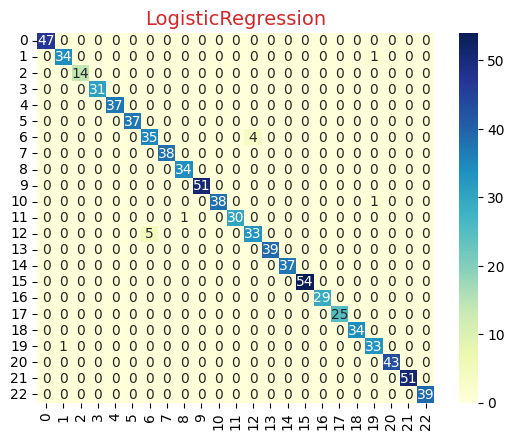

DecisionTree:
accuracy: 1.0


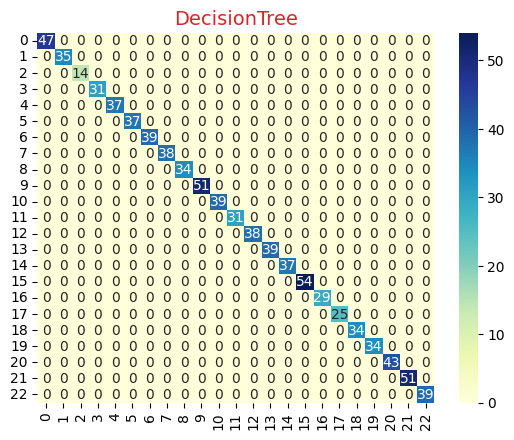

RandomForest:
accuracy: 1.0


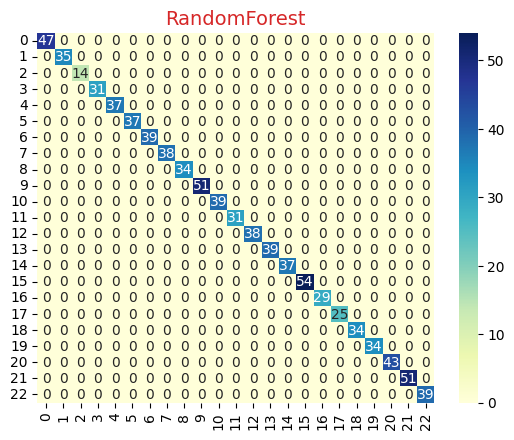

XGBoost:
accuracy: 1.0


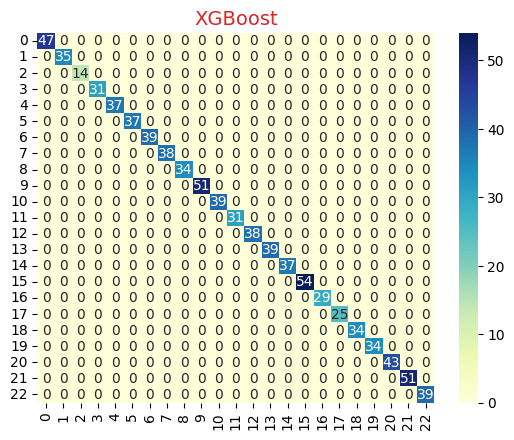

In [44]:
eva(lr.predict_proba(x_test), 'LogisticRegression')
eva(tree.predict_proba(x_test), 'DecisionTree')
eva(rfc.predict_proba(x_test), 'RandomForest')
eva(xgb.predict_proba(x_test), 'XGBoost')

In [45]:
tree.predict_proba(x_test)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
rfc.predict_proba(x_test)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [47]:
lr.predict_proba(x_test[20:21])

array([[3.39816067e-013, 2.08531717e-029, 3.81178009e-048,
        1.46283781e-123, 3.79439076e-045, 7.41358496e-037,
        1.45218965e-197, 7.63722139e-038, 5.16261883e-230,
        6.27901167e-069, 3.04712001e-014, 2.93356231e-156,
        1.46486565e-243, 9.99993706e-001, 5.81367216e-123,
        1.55171040e-046, 1.25512820e-008, 9.61014795e-035,
        2.38669754e-059, 2.13490082e-011, 4.49640165e-008,
        6.23673572e-006, 1.90650750e-099]])

In [48]:
xgb.predict_proba(x_test[20:21])

array([[1.5005462e-04, 1.9119825e-04, 1.3175547e-04, 9.8799035e-05,
        1.6872607e-04, 1.6822446e-04, 1.0817072e-04, 1.3652066e-04,
        1.2933975e-04, 1.7426773e-04, 1.1148763e-04, 9.1424990e-05,
        1.0459688e-04, 9.9662763e-01, 1.0650425e-04, 1.6685022e-04,
        1.3749565e-04, 1.3407445e-04, 1.1695196e-04, 2.0090981e-04,
        4.4892123e-04, 1.9977396e-04, 9.6316529e-05]], dtype=float32)

In [49]:
pd.DataFrame(lr.predict_proba(x_test[20:21]), columns=res.keys()).T.sort_values(by=0)

,0
Stanford University,1.464866e-243
Massachusetts Institute of Technology,5.162619e-230
Harvard University,1.452190e-197
Princeton University,2.933562e-156
Columbia University,1.462838e-123
University of California Berkeley,5.813672e-123
Yale University,1.906508e-99
New York University,6.279012e-69
University of Pennsylvania,2.386698e-59
Carnegie Mellon University,3.811780e-48


In [50]:
pd.DataFrame(xgb.predict_proba(x_test[20:21]), columns=res.keys()).T.sort_values(by=0)

,0
Princeton University,0.000091
Yale University,0.000096
Columbia University,0.000099
Stanford University,0.000105
University of California Berkeley,0.000107
Harvard University,0.000108
Northwestern University,0.000111
University of Pennsylvania,0.000117
Massachusetts Institute of Technology,0.000129
Carnegie Mellon University,0.000132


In [51]:
# save model
joblib.dump(xgb, 'models/model.pkl')

['models/model.pkl']

In [38]:
model = joblib.load('models/model.pkl')

In [40]:
x_test[20:21]

array([[  9.        ,  16.        ,  23.        ,  30.        ,
        138.        ,  73.        ,   8.6       ,   8.        ,
          1.        ,   4.10344828,   3.32184466,  12.15048544,
          2.66893204,   3.74468085]])

In [44]:
import numpy as np

In [47]:
np.array([9.,16.,23.,30.,138.,73.,8.6,8.,1.,4.10344828,3.32184466,12.15048544,2.66893204,3.74468085])

array([  9.        ,  16.        ,  23.        ,  30.        ,
       138.        ,  73.        ,   8.6       ,   8.        ,
         1.        ,   4.10344828,   3.32184466,  12.15048544,
         2.66893204,   3.74468085])

In [48]:
model.predict_proba(x_test[20:21])

array([[1.5005462e-04, 1.9119825e-04, 1.3175547e-04, 9.8799035e-05,
        1.6872607e-04, 1.6822446e-04, 1.0817072e-04, 1.3652066e-04,
        1.2933975e-04, 1.7426773e-04, 1.1148763e-04, 9.1424990e-05,
        1.0459688e-04, 9.9662763e-01, 1.0650425e-04, 1.6685022e-04,
        1.3749565e-04, 1.3407445e-04, 1.1695196e-04, 2.0090981e-04,
        4.4892123e-04, 1.9977396e-04, 9.6316529e-05]], dtype=float32)

In [41]:
[7.,3.,14.818,86.15,28.5,79.473,12.98708572,11.77142857,0.,3.855,0.5,7.,0.45,2.84752852]

[7.0,
 3.0,
 14.818,
 86.15,
 28.5,
 79.473,
 12.98708572,
 11.77142857,
 0.0,
 3.855,
 0.5,
 7.0,
 0.45,
 2.84752852]

In [2]:
import joblib

In [4]:
joblib.load('models/model.pkl')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)